In [1]:
!pip install tables
!pip install mplsoccer

     |████████████████████████████████| 5.9 MB 514 kB/s            
     |████████████████████████████████| 58 kB 499 kB/s            
  Preparing metadata (setup.py) ... - done
  Created wheel for mplsoccer: filename=mplsoccer-1.0.6-py3-none-any.whl size=62946 sha256=1834733fba1042517753210070cb8beec3684eebced72985e56afbcf09bb4f0c
  Stored in directory: /root/.cache/pip/wheels/ff/fc/ed/09e6cb7c61780f5462f1dfd1df7d1fabef0123ced961ac0738
Successfully built mplsoccer


In [2]:
!pip install hdbscan

     |████████████████████████████████| 5.2 MB 518 kB/s            
  Installing build dependencies ... - \ | / - \ | / done
  Getting requirements to build wheel ... - \ | / done
  Preparing metadata (pyproject.toml) ... - \ | / done
  Created wheel for hdbscan: filename=hdbscan-0.8.28-cp37-cp37m-linux_x86_64.whl size=3428490 sha256=97fb0445b86a3abe0295212a2c0d38850517bd31eeb35e35a3d353b0a59f342f
  Stored in directory: /root/.cache/pip/wheels/6e/7a/5e/259ccc841c085fc41b99ef4a71e896b62f5161f2bc8a14c97a
Successfully built hdbscan


In [3]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.patches import Arc
import bz2
from glob import glob
import imageio
import json
import os

In [4]:
def create_pitch(length, width, linecolor, bounds = 15):

    """
    mainly stolen from fc python
    param length: an int the length of the field
    param width: an int the height of the field
    param linecolor: the color of the lines
"""
    #Create figure
    fig=plt.figure()
    #fig.set_size_inches(7, 5)
    ax=fig.add_subplot(1,1,1)

    #Pitch Outline & Centre Line
    plt.plot([0,0],[0,width], color=linecolor)
    plt.plot([0,length],[width,width], color=linecolor)
    plt.plot([length,length],[width,0], color=linecolor)
    plt.plot([length,0],[0,0], color=linecolor)
    plt.plot([length/2,length/2],[0,width], color=linecolor)
    plt.fill_between(x = [-bounds, length+bounds],
                     y1 = [width+bounds, width + bounds],
                     y2 = [-bounds, -bounds], color='green')

    #Left Penalty Area
    plt.plot([16.5 ,16.5],[(width/2 +16.5),(width/2-16.5)],color=linecolor)
    plt.plot([0,16.5],[(width/2 +16.5),(width/2 +16.5)],color=linecolor)
    plt.plot([16.5,0],[(width/2 -16.5),(width/2 -16.5)],color=linecolor)

    #Right Penalty Area
    plt.plot([(length-16.5),length],[(width/2 +16.5),(width/2 +16.5)],color=linecolor)
    plt.plot([(length-16.5), (length-16.5)],[(width/2 +16.5),(width/2-16.5)],color=linecolor)
    plt.plot([(length-16.5),length],[(width/2 -16.5),(width/2 -16.5)],color=linecolor)

    #Left 5-meters Box
    plt.plot([0,5.5],[(width/2+7.32/2+5.5),(width/2+7.32/2+5.5)],color=linecolor)
    plt.plot([5.5,5.5],[(width/2+7.32/2+5.5),(width/2-7.32/2-5.5)],color=linecolor)
    plt.plot([5.5,0.5],[(width/2-7.32/2-5.5),(width/2-7.32/2-5.5)],color=linecolor)

    #Right 5-meters Box
    plt.plot([length,length-5.5],[(width/2+7.32/2+5.5),(width/2+7.32/2+5.5)],color=linecolor)
    plt.plot([length-5.5,length-5.5],[(width/2+7.32/2+5.5),width/2-7.32/2-5.5],color=linecolor)
    plt.plot([length-5.5,length],[width/2-7.32/2-5.5,width/2-7.32/2-5.5],color=linecolor)

    #Prepare Circles
    centreCircle = plt.Circle((length/2,width/2),9.15,color=linecolor,fill=False)
    centreSpot = plt.Circle((length/2,width/2),0.8,color=linecolor)
    leftPenSpot = plt.Circle((11,width/2),0.8,color=linecolor)
    rightPenSpot = plt.Circle((length-11,width/2),0.8,color=linecolor)

    #Draw Circles
    ax.add_patch(centreCircle)
    ax.add_patch(centreSpot)
    ax.add_patch(leftPenSpot)
    ax.add_patch(rightPenSpot)

    #Prepare Arcs
    leftArc = Arc((11,width/2),height=18.3,width=18.3,angle=0,theta1=308,theta2=52,color=linecolor)
    rightArc = Arc((length-11,width/2),height=18.3,width=18.3,angle=0,theta1=128,theta2=232,color=linecolor)

    #Draw Arcs
    ax.add_patch(leftArc)
    ax.add_patch(rightArc)
            #Axis titles
    #Tidy Axes
    plt.axis('off')
    
    return fig,ax

In [5]:
data_path = '../input/socceranalytics/events/events/'
team = 'Italy'
json_matches_path = '../input/socceranalytics/matches.json'

def all_matches(team, data_path):
    match_ids = get_all_matchids(team)
    all_team_df, dfs = get_all_matchdfs(match_ids, data_path)
    return all_team_df, dfs

def get_all_matchids(team):
    '''
    given a team name i.e. "Italy", returns a list of all match_ids by italy
    '''
    with open(json_matches_path) as f:
        data = json.load(f)
        matches = pd.json_normalize(data, sep = "_")
    #get mask for team
    mask = (matches["home_team_home_team_name"] == team) | (matches["away_team_away_team_name"] == team)
    team_matches = matches[mask]
    match_ids = []
    for match in team_matches.match_id:
        match_ids.append(match)
    return match_ids

def get_all_matchdfs(match_ids, data_path):
    '''
    takes a list of matches and a datapath to all match_data and returns
    a concatenated dataframe + a dictionary of dataframes 
    with all dataframes for those match_ids
    param: match_ids, list of strings match_ids
    param: data_path, string, path to json files
    '''
    dfs = dict()
    for match_id in match_ids:
        zipfile = bz2.BZ2File(data_path + f"{match_id}.json.bz2")
        file = zipfile.read()
        open(f"{match_id}.json", 'wb').write(file)
        with open(f"{match_id}.json") as f:
            events = json.load(f)
            df = pd.json_normalize(events[2:], sep = "_")
            df['match_id'] = match_id
            dfs[match_id] = df
    match_dfs = []
    for key, df in dfs.items():
        match_dfs.append(df)
    return pd.concat(match_dfs), dfs

In [6]:
def time_to_mins(timestring):
    minute = list(map(float, timestring.split(":")))[1]
    return minute

In [7]:
all_italy_df, dfs = all_matches('Italy', data_path)

In [8]:
all_wales_df, dfs_w = all_matches('Wales', data_path)

In [9]:
with open('../input/socceranalytics/matches.json') as f:
    data = json.load(f)
    matches = pd.json_normalize(data, sep = "_")
    
to_drop = ['away_team_away_team_gender',
           'home_team_home_team_gender',
           'competition_country_name',
           'competition_competition_id',
           'last_updated_360',
           'last_updated',
           'season_season_name',
           'competition_competition_name',
           'competition_competition_id',
           'match_status',
           'metadata_shot_fidelity_version',
           'match_week']
matches = matches.drop(to_drop, axis=1)

In [10]:
matches.head()

,match_id,match_date,kick_off,home_score,away_score,match_status_360,season_season_id,home_team_home_team_id,home_team_home_team_name,home_team_home_team_group,...,competition_stage_id,competition_stage_name,stadium_id,stadium_name,stadium_country_id,stadium_country_name,referee_id,referee_name,referee_country_id,referee_country_name
0,3788753,2021-06-16,15:00:00.000,0,1,available,43,1835,Finland,Group B,...,10,Group Stage,4726,Saint-Petersburg Stadium,188,Russia,293,Danny Desmond Makkelie,160,Netherlands
1,3788765,2021-06-20,18:00:00.000,3,1,available,43,773,Switzerland,Group A,...,10,Group Stage,4549,Bakı Olimpiya Stadionu,16,Azerbaijan,943,Slavko Vinčić,208,Slovenia
2,3795107,2021-07-02,21:00:00.000,1,2,available,43,782,Belgium,None,...,11,Quarter-finals,4867,Allianz Arena (München),85,Germany,943,Slavko Vinčić,208,Slovenia
3,3795221,2021-07-07,21:00:00.000,2,1,available,43,768,England,None,...,15,Semi-finals,4666,Wembley Stadium (London),68,England,293,Danny Desmond Makkelie,160,Netherlands
4,3795506,2021-07-11,21:00:00.000,1,1,available,43,914,Italy,None,...,26,Final,4666,Wembley Stadium (London),68,England,287,Björn Kuipers,160,Netherlands


In [11]:
#drop 0 variance columns
matches.loc[:, (matches != matches.iloc[0]).any()].shape

(51, 27)

In [12]:
mask = (matches["home_team_home_team_name"] == "Italy") | (matches["away_team_away_team_name"] == "Italy")
italy_matches = matches[mask]
mask = (matches["home_team_home_team_name"] == "Wales") | (matches["away_team_away_team_name"] == "Wales")
wales_matches = matches[mask]

In [13]:
italy_match_ids = []
wales_match_ids = []
for match in italy_matches.match_id:
    italy_match_ids.append(match)
for match in wales_matches.match_id:
    wales_match_ids.append(match)

In [14]:
data_path = '../input/socceranalytics/events/events'
files = glob(data_path +'/*.json.bz2')

In [15]:
bins = [i for i in range(0, 130, 5)]
all_italy_df['minute_bins'] = pd.cut(all_italy_df.minute + 1, bins = bins, labels = bins.append(130), retbins = True)[0].apply(lambda x: x.right)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:2: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  


In [16]:
all_italy_df.minute_bins

0         5
1         5
2         5
3         5
4         5
       ... 
4820    130
4821    130
4822    130
4823    130
4824    130
Name: minute_bins, Length: 28869, dtype: category
Categories (26, int64): [5 < 10 < 15 < 20 ... 115 < 120 < 125 < 130]

In [17]:
def restore_df(path):
    with pd.HDFStore(path, mode = 'r') as store:
        df = store.get('df')
        df.attrs = store.get_storer('df').attrs.my_attribute
        return df

In [18]:
iw_track = restore_df("../input/socceranalytics/dfmeta/dfmeta/italyvwales.h5")
player_map = iw_track.attrs['player_map']
pos_cols = [col for col in iw_track if 'x' in col or 'y' in col]

In [19]:
for key in player_map.keys():
    try:
        iw_track[str(key) + "_distance"] = (iw_track[str(key) + "_x"] - iw_track['ball_x'])**2
        iw_track[str(key) + "_distance"] += (iw_track[str(key) + "_y"] - iw_track['ball_y'])**2
        iw_track[str(key) + "_distance"] = iw_track[str(key) + "_distance"].apply(np.sqrt)
    except:
        print(f"{player_map[key]} did not play")

Alex Meret did not play
Giovanni Di Lorenzo did not play
Giorgio Chiellini did not play
Leonardo Spinazzola did not play
Alessandro Florenzi did not play
Manuel Locatelli did not play
Nicolò Barella did not play
Lorenzo Insigne did not play
Domenico Berardi did not play
Ciro Immobile did not play
Wayne Hennessey did not play
Adam Davies did not play
Tom Lockyer did not play
Rhys Norrington-Davies did not play
Chris Mepham did not play
Ben Cabango did not play
Jonny Williams did not play
Rubin Colwill did not play
Matthew Smith did not play
Tyler Roberts did not play


In [20]:
import mplsoccer.statsbomb as sbapi

In [21]:
match_id = "3788766"
zipfile = bz2.BZ2File(data_path + f"/{match_id}.json.bz2")
file = zipfile.read()
open(f"{match_id}.json", 'wb').write(file)
dict_event = sbapi.read_event(f"{match_id}.json", warn = False)
df_event = dict_event['event']
df_related_event = dict_event['related_event']
df_shot_freeze = dict_event['shot_freeze_frame']
df_tactics_lineup = dict_event['tactics_lineup']

In [22]:
df_tactics_lineup

,id,event_tactics_id,player_jersey_number,player_id,player_name,player_position_id,player_position_name,match_id
0,bf809b76-62f7-4a52-85f3-1fb45c84b5e2,1,21,7036,Gianluigi Donnarumma,1,Goalkeeper,3788766
1,7bc4e41d-c539-4322-89b5-f8e771523012,1,12,9914,Danny Ward,1,Goalkeeper,3788766
2,2b649a47-3ec8-4f8d-8714-b4e10c163876,1,21,7036,Gianluigi Donnarumma,1,Goalkeeper,3788766
3,9046168f-9a9f-4fb2-8a88-a9407aabd5b9,1,21,7036,Gianluigi Donnarumma,1,Goalkeeper,3788766
4,46b8dfae-00ce-4a76-9c81-872d86c16288,1,21,7036,Gianluigi Donnarumma,1,Goalkeeper,3788766
5,bf809b76-62f7-4a52-85f3-1fb45c84b5e2,2,25,7002,Rafael Tolói,2,Right Back,3788766
6,7bc4e41d-c539-4322-89b5-f8e771523012,2,6,11250,Joe Rodon,3,Right Center Back,3788766
7,2b649a47-3ec8-4f8d-8714-b4e10c163876,2,25,7002,Rafael Tolói,2,Right Back,3788766
8,9046168f-9a9f-4fb2-8a88-a9407aabd5b9,2,25,7002,Rafael Tolói,2,Right Back,3788766
9,46b8dfae-00ce-4a76-9c81-872d86c16288,2,25,7002,Rafael Tolói,2,Right Back,3788766


In [23]:
df_event.columns

Index(['match_id', 'id', 'index', 'period', 'timestamp_minute',
       'timestamp_second', 'timestamp_millisecond', 'minute', 'second',
       'type_id', 'type_name', 'sub_type_id', 'sub_type_name', 'outcome_id',
       'outcome_name', 'play_pattern_id', 'play_pattern_name',
       'possession_team_id', 'possession', 'possession_team_name', 'team_id',
       'team_name', 'player_id', 'player_name', 'position_id', 'position_name',
       'duration', 'x', 'y', 'z', 'end_x', 'end_y', 'end_z', 'body_part_id',
       'body_part_name', 'technique_id', 'technique_name', 'under_pressure',
       'counterpress', 'off_camera', 'out', 'pass_length', 'pass_angle',
       'pass_recipient_id', 'pass_recipient_name', 'pass_height_id',
       'pass_height_name', 'pass_switch', 'pass_cross',
       'pass_assisted_shot_id', 'pass_shot_assist', 'pass_cut_back',
       'pass_goal_assist', 'ball_recovery_recovery_failure',
       'block_deflection', 'dribble_nutmeg', 'foul_committed_advantage',
       'fou

In [24]:
dr = df_event[df_event.type_name == "Dribble"]
dr.groupby(['possession_team_name']).size()

possession_team_name
Italy    13
Wales     5
dtype: int64

In [25]:
interest = ['period', 'timestamp_minute',
       'timestamp_second', 'minute', 'second',
       'sub_type_name',
       'outcome_name', 'play_pattern_name','possession', 'possession_team_name',
       'team_name', 'player_name', 'position_name',
       'duration', 'x', 'y', 'end_x', 'end_y',
       'body_part_name', 'technique_name', 'under_pressure', 'off_camera', 'out', 'pass_length', 'pass_angle',
       'pass_recipient_name',
       'pass_height_name', 'pass_switch', 'pass_cross', 'pass_shot_assist', 'pass_cut_back',
       'pass_goal_assist']

In [26]:
df = df_event

In [27]:
attacks = df[(df.type_name == 'Clearance') | (df.type_name == 'Shot')]
attack_p = attacks.possession.unique()
attacks = df[df.possession.isin(attack_p)]

In [28]:
attacksi = attacks[(attacks.possession_team_name == "Italy")]
attacksw = attacks[attacks.possession_team_name == "Wales"]

In [29]:
invoi = attacksi.groupby(['possession', 'player_name']).size().reset_index()
invoi.columns = ['poss', 'player', 'count']
invoi['total'] = invoi.groupby('poss')['count'].transform('sum').to_numpy()
invoi['ratio'] = invoi['count'] / invoi['total']

In [30]:
invow = attacksw.groupby(['possession', 'player_name']).size().reset_index()
invow.columns = ['poss', 'player', 'count']
invow['total'] = invow.groupby('poss')['count'].transform('sum').to_numpy()
invow['ratio'] = invow['count'] / invow['total']

In [31]:
invoi.player.value_counts()

Danny Ward                         19
Marco Verratti                     19
Alessandro Bastoni                 16
Federico Chiesa                    16
Rafael Tolói                       15
Emerson Palmieri dos Santos        13
Jorge Luiz Frello Filho            13
Matteo Pessina                     13
Federico Bernardeschi              13
Joe Rodon                          10
Francesco Acerbi                   10
Neco Williams                       9
Andrea Belotti                      9
Aaron Ramsey                        8
Joseff Morrell                      8
Leonardo Bonucci                    7
Chris Gunter                        7
Joe Allen                           6
Gianluigi Donnarumma                5
Ethan Ampadu                        5
Bryan Cristante                     5
Giacomo Raspadori                   4
Daniel James                        3
Connor Roberts                      3
Gaetano Castrovilli                 3
Dylan Levitt                        3
Kieffer Robe

In [32]:
xg_ = attacksi[attacksi.shot_statsbomb_xg > 0].groupby('possession').shot_statsbomb_xg.sum().reset_index()
xg_dict = dict(zip(xg_.iloc[:, 0], xg_.iloc[:, 1]))

In [33]:
def map_xg(x):
    try:
        return xg_dict[x]
    except:
        return 0
invoi['xg'] = invoi.poss.apply(map_xg)

In [34]:
invoi

,poss,player,count,total,ratio,xg
0,21,Alessandro Bastoni,10,46,0.217391,0.313013
1,21,Andrea Belotti,2,46,0.043478,0.313013
2,21,Danny Ward,1,46,0.021739,0.313013
3,21,Emerson Palmieri dos Santos,3,46,0.065217,0.313013
4,21,Jorge Luiz Frello Filho,5,46,0.108696,0.313013
...,...,...,...,...,...,...
248,156,Federico Chiesa,3,29,0.103448,0.000000
249,156,Francesco Acerbi,5,29,0.172414,0.000000
250,156,Gaetano Castrovilli,3,29,0.103448,0.000000
251,156,Marco Verratti,6,29,0.206897,0.000000


In [35]:
invoi['xg_ratio'] = invoi['ratio'] * invoi['xg']

In [36]:
attacksi[attacksi.player_name == 'Aaron Ramsey']['type_name']

640      Pressure
1092     Pressure
1263     Pressure
2292    Clearance
2315     Pressure
2378     Pressure
2380        Block
2796        Block
2912     Pressure
Name: type_name, dtype: object

In [37]:
wales_players = ['Joseff Morrell',
                 'Aaron Ramsey',
                 'Chris Gunter',
                 'Connor Roberts',
                 'Danny Ward',
                 'David Brooks',
                 'Dylan Levitt',
                 'Ethan Ampadu',
                 'Harry Wilson',
                 'Joe Allen',
                 'Joe Rodon',
                 'Kieffer Roberto Francisco Moore',
                'Gareth Frank Bale',
                ]

In [38]:
invoi = invoi[~invoi.player.isin(wales_players)]
sumi = invoi.groupby('player').sum()

In [39]:
sumi = sumi.reset_index()
sumi.sort_values(by = 'xg')

,player,poss,count,total,ratio,xg,xg_ratio
17,Salvatore Sirigu,155,2,104,0.019231,0.018741,0.000360
3,Daniel James,199,5,141,0.126504,0.113376,0.002922
8,Gaetano Castrovilli,463,10,215,0.173336,0.174771,0.002984
2,Bryan Cristante,761,37,367,0.493560,0.205231,0.020356
9,Giacomo Raspadori,599,9,243,0.248271,0.212643,0.009139
10,Gianluigi Donnarumma,435,12,227,0.300023,0.340819,0.023293
7,Francesco Acerbi,1347,92,587,1.374205,0.462410,0.061709
15,Neco Williams,882,15,392,0.830800,0.481173,0.019436
6,Federico Chiesa,1806,84,785,2.228289,0.944905,0.115472
16,Rafael Tolói,1456,81,741,1.933657,1.088525,0.145877


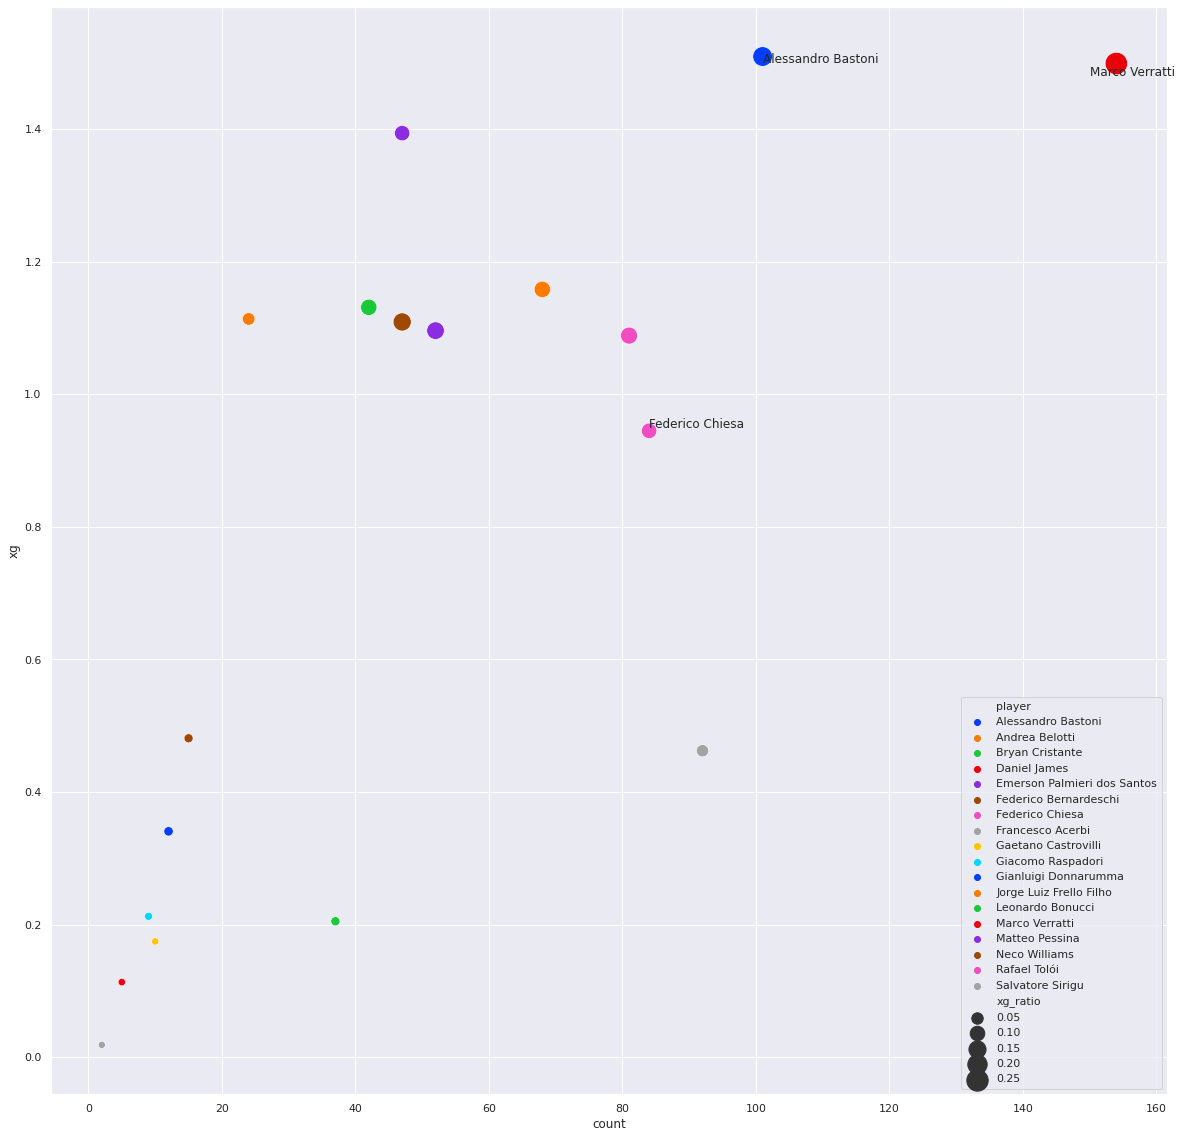

In [40]:
sns.set(style="darkgrid")   
sns.set(font_scale = 5)
sns.set(rc={'figure.figsize':(20,20)}) 
g = sns.scatterplot(data= sumi, x = 'count', y = 'xg', hue = 'player', size = 'xg_ratio', sizes = (50, 500), palette = 'bright')
plt.text(150, 1.48, 'Marco Verratti')
plt.text(101, 1.5, 'Alessandro Bastoni')
plt.text(84, 0.95, 'Federico Chiesa')
g.legend(loc = 'lower right', bbox_to_anchor=(1, 0), ncol=1)
plt.savefig('involvements_italy.png')
plt.show()

In [41]:
xg_ = attacksw[attacksw.shot_statsbomb_xg > 0].groupby('possession').shot_statsbomb_xg.sum().reset_index()
xg_dict = dict(zip(xg_.iloc[:, 0], xg_.iloc[:, 1]))

def map_xg(x):
    try:
        return xg_dict[x]
    except:
        return 0
invow['xg'] = invow.poss.apply(map_xg)
invow['xg_ratio'] = invow['ratio'] * invow['xg']

In [42]:
iplayers = [
    'Marco Verratti',
    'Alessandro Bastoni',
    'Matteo Pessina',
    'Emerson Palmieri dos Santos',
    'Andrea Belotti',
    'Leonardo Bonucci',
    'Gianluigi Donnarumma',
    'Rafael Tolói',
    'Federico Bernardeschi',
    'Jorge Luiz Frello Filho',
    'Francesco Acerbi',
    'Giacomo Raspadori',
    'Bryan Cristante'
]

In [43]:
invow = invow[~invow.player.isin(iplayers)]
sumw = invow.groupby('player').sum()

In [44]:
sumw = sumw.reset_index()
sumw.sort_values(by = 'xg')

,player,poss,count,total,ratio,xg,xg_ratio
0,Aaron Ramsey,771,29,158,1.507089,0.000000,0.000000
4,Danny Ward,478,11,42,1.227778,0.000000,0.000000
5,Ethan Ampadu,259,11,109,0.311688,0.000000,0.000000
7,Joe Allen,393,11,124,0.424838,0.000000,0.000000
9,Joseff Morrell,169,10,99,0.299874,0.000000,0.000000
10,Kieffer Roberto Francisco Moore,837,11,53,1.856151,0.000000,0.000000
11,Neco Williams,503,15,121,0.921320,0.000000,0.000000
1,Chris Gunter,328,17,111,1.118687,0.065273,0.032636
3,Daniel James,258,4,14,0.869048,0.082458,0.022047
2,Connor Roberts,1000,24,190,1.554798,0.378296,0.063049


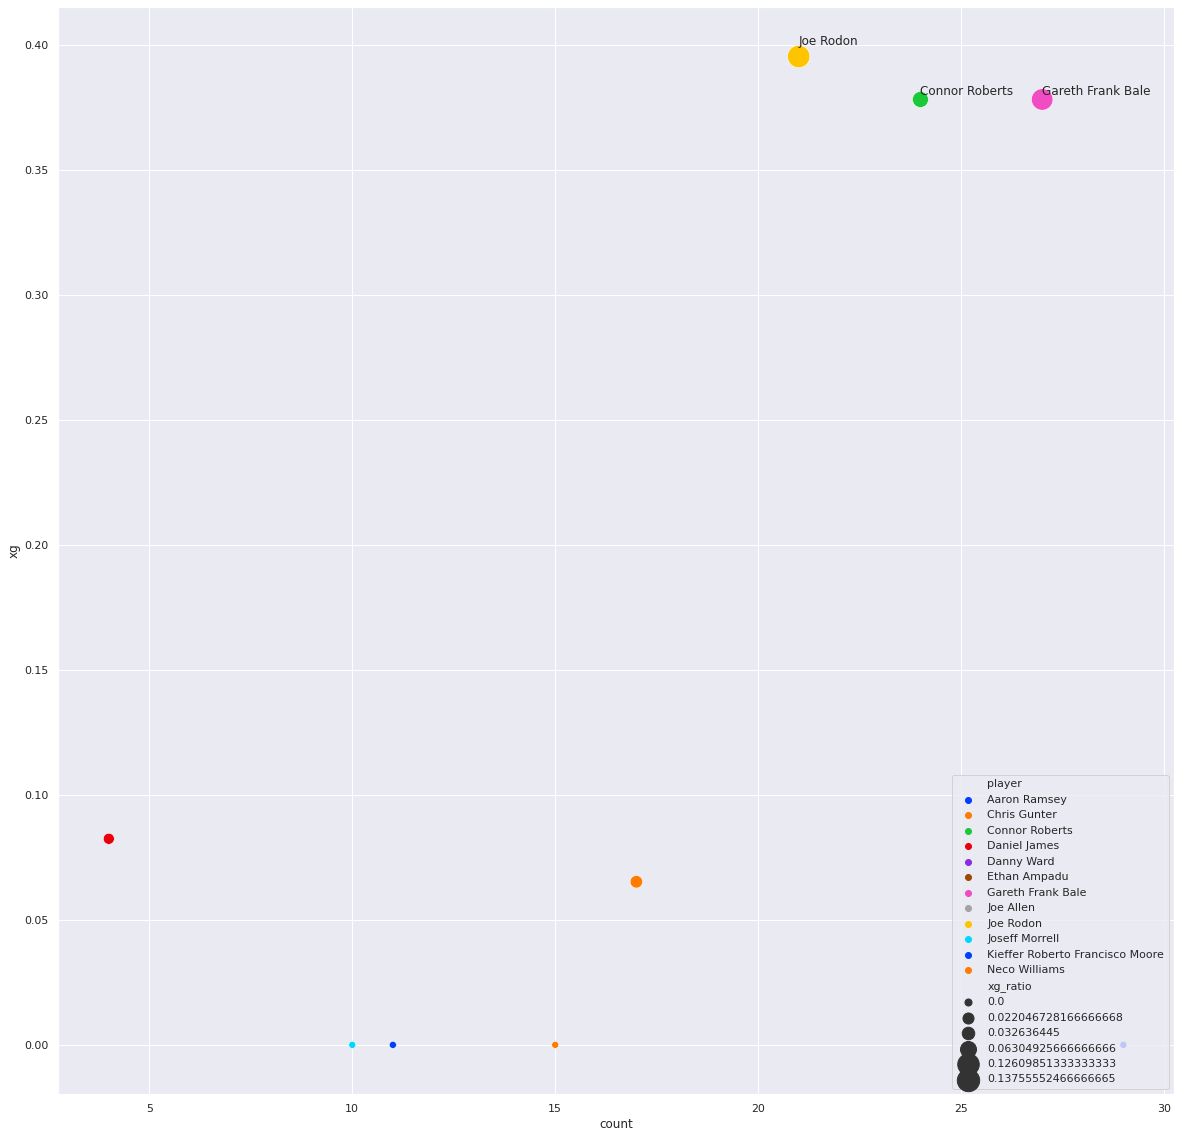

In [45]:
sns.set(style="darkgrid")   
sns.set(font_scale = 5)
sns.set(rc={'figure.figsize':(20,20)}) 
g = sns.scatterplot(data= sumw, x = 'count', y = 'xg', hue = 'player', size = 'xg_ratio', sizes = (50, 500), palette = 'bright')
plt.text(21, 0.4, 'Joe Rodon')
plt.text(27, 0.38, 'Gareth Frank Bale')
plt.text(24, 0.38, 'Connor Roberts')
g.legend(loc = 'lower right', bbox_to_anchor=(1, 0), ncol=1)
plt.savefig('involvements_wales.png')
plt.show()

In [46]:
invow.player.value_counts()

Connor Roberts                     10
Gareth Frank Bale                  10
Joe Rodon                          10
Aaron Ramsey                        7
Kieffer Roberto Francisco Moore     6
Chris Gunter                        5
Danny Ward                          5
Neco Williams                       5
Joe Allen                           4
Joseff Morrell                      3
Ethan Ampadu                        3
Daniel James                        3
Name: player, dtype: int64